In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import random

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


2025-08-02 19:17:18.779293: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754162238.996831      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754162239.064753      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:

data_dir = "/kaggle/input/lgg-mri-segmentation/kaggle_3m"
data_map = []

for sub_dir_path in glob.glob(os.path.join(data_dir, "*")):
    if os.path.isdir(sub_dir_path): 
        dir_name = os.path.basename(sub_dir_path)
        for filename in os.listdir(sub_dir_path):
            image_path = os.path.join(sub_dir_path, filename)
            data_map.extend([dir_name, image_path])

# Create base dataframe
df = pd.DataFrame({"patient_id" : data_map[::2], "path" : data_map[1::2]})

# Separate images and masks
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]


In [3]:

BASE_LEN = len(data_dir) + 1 + 35  
END_IMG_LEN = 4  
END_MASK_LEN = 9  

imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

brain_df = pd.DataFrame({
    "patient_id": df_imgs.patient_id.values,
    "image_path": imgs,
    "mask_path": masks
})

def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    return 1 if value > 0 else 0

brain_df['mask'] = brain_df['mask_path'].apply(pos_neg_diagnosis)


In [20]:
brain_df

,patient_id,image_path,mask_path,mask
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
...,...,...,...,...
3924,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3925,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3926,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3927,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


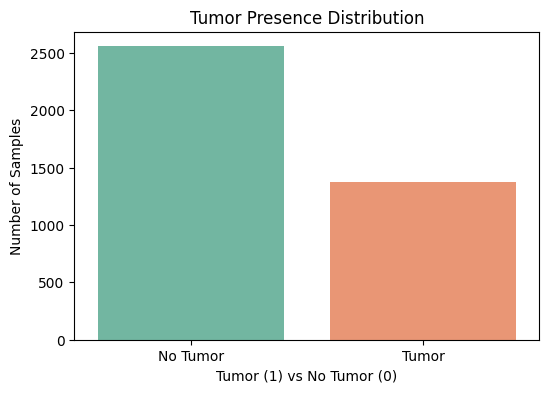

In [4]:
plt.figure(figsize=(6,4))
sns.countplot(data=brain_df, x='mask', palette='Set2')
plt.title("Tumor Presence Distribution")
plt.xlabel("Tumor (1) vs No Tumor (0)")
plt.ylabel("Number of Samples")
plt.xticks([0, 1], ['No Tumor', 'Tumor'])
plt.show()


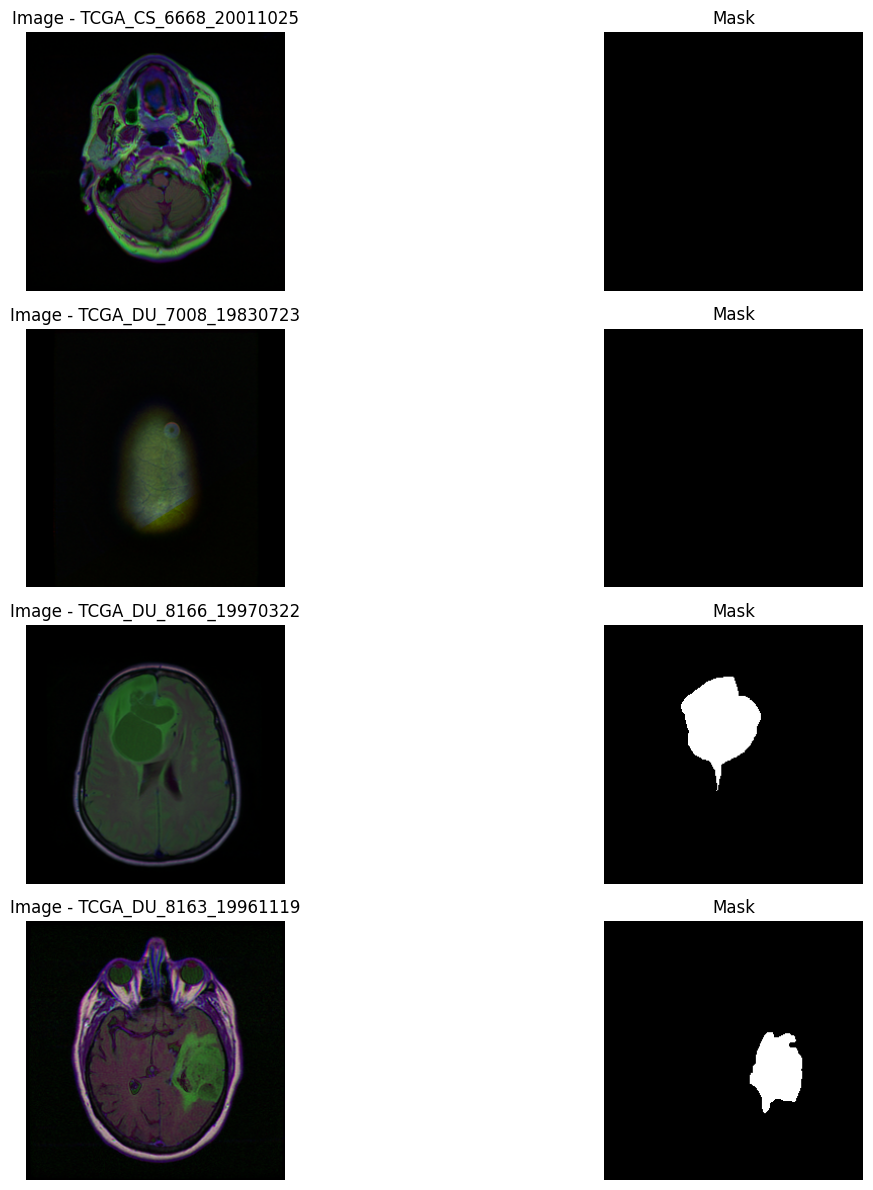

In [5]:

def show_samples(df, n=5):
    plt.figure(figsize=(15, n * 3))
    for i in range(n):
        idx = random.randint(0, len(df)-1)
        img = cv2.imread(df.iloc[idx]['image_path'])
        mask = cv2.imread(df.iloc[idx]['mask_path'], cv2.IMREAD_GRAYSCALE)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(n, 2, 2*i + 1)
        plt.imshow(img)
        plt.title(f"Image - {df.iloc[idx]['patient_id']}")
        plt.axis('off')

        plt.subplot(n, 2, 2*i + 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_samples(brain_df, n=4)


In [7]:

IMG_SIZE = 256

def preprocess_image(path, is_mask=False):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    if is_mask:
        img = (img > 0).astype(np.uint8)  
    else:
        img = img / 255.0  

    return img.reshape(IMG_SIZE, IMG_SIZE, 1)


X = np.array([preprocess_image(p, is_mask=False) for p in brain_df['image_path']])
y = np.array([preprocess_image(p, is_mask=True) for p in brain_df['mask_path']])


In [ ]:

def preprocess_image(path, is_mask=False):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    interpolation = cv2.INTER_NEAREST if is_mask else cv2.INTER_AREA
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=interpolation)

    if is_mask:
        img = (img > 0).astype(np.uint8)  
    else:
        img = img / 255.0  

    return img.reshape(IMG_SIZE, IMG_SIZE, 1)
X = np.array([preprocess_image(p, is_mask=False) for p in brain_df['image_path']])
y = np.array([preprocess_image(p, is_mask=True) for p in brain_df['mask_path']])


In [8]:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)


In [9]:

def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)

    # Decoder
    u4 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    m4 = Concatenate()([u4, c4])
    c4d = Conv2D(512, (3, 3), activation='relu', padding='same')(m4)

    u5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4d)
    m5 = Concatenate()([u5, c3])
    c5d = Conv2D(256, (3, 3), activation='relu', padding='same')(m5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5d)
    m6 = Concatenate()([u6, c2])
    c6d = Conv2D(128, (3, 3), activation='relu', padding='same')(m6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6d)
    m7 = Concatenate()([u7, c1])
    c7d = Conv2D(64, (3, 3), activation='relu', padding='same')(m7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7d)

    model = Model(inputs, outputs)
    return model


In [10]:

model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_unet_model.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=3)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=16,
    callbacks=[early_stop, checkpoint, reduce_lr]
)


I0000 00:00:1754162347.431789      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754162347.432563      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/25


I0000 00:00:1754162357.253746     108 service.cc:148] XLA service 0x7817e401e700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754162357.254360     108 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754162357.254387     108 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754162357.911201     108 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1754162398.218257     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


208/209 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.9619 - loss: 0.1972

E0000 00:00:1754162511.163307     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754162511.403521     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754162523.156628     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754162523.397441     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.9620 - loss: 0.1966

E0000 00:00:1754162571.986882     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754162572.228804     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


209/209 ━━━━━━━━━━━━━━━━━━━━ 224s 853ms/step - accuracy: 0.9621 - loss: 0.1961 - val_accuracy: 0.9905 - val_loss: 0.0363 - learning_rate: 0.0010
Epoch 2/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 117s 562ms/step - accuracy: 0.9894 - loss: 0.0373 - val_accuracy: 0.9905 - val_loss: 0.0343 - learning_rate: 0.0010
Epoch 3/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 118s 562ms/step - accuracy: 0.9895 - loss: 0.0357 - val_accuracy: 0.9905 - val_loss: 0.0318 - learning_rate: 0.0010
Epoch 4/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 118s 563ms/step - accuracy: 0.9898 - loss: 0.0337 - val_accuracy: 0.9908 - val_loss: 0.0316 - learning_rate: 0.0010
Epoch 5/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 118s 564ms/step - accuracy: 0.9903 - loss: 0.0329 - val_accuracy: 0.9908 - val_loss: 0.0312 - learning_rate: 0.0010
Epoch 6/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 118s 563ms/step - accuracy: 0.9904 - loss: 0.0328 - val_accuracy: 0.9917 - val_loss: 0.0290 - learning_rate: 0.0010
Epoch 7/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 117s 562ms/step - accuracy: 0.9906 

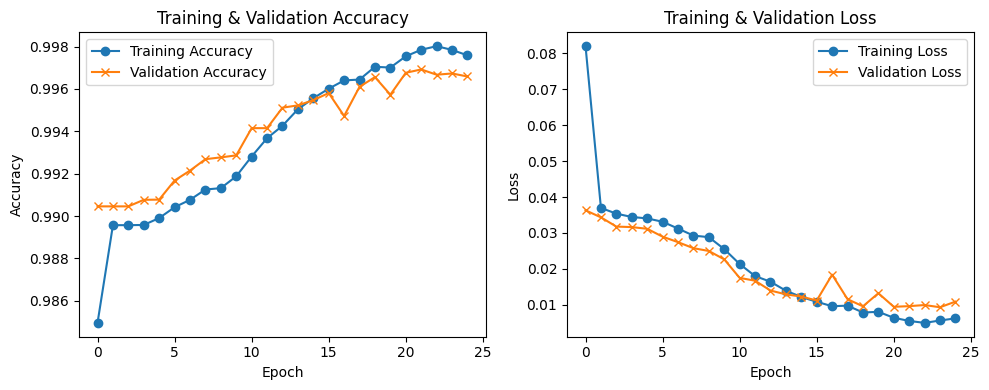

In [11]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [12]:

final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


Final Training Accuracy: 0.9976
Final Validation Accuracy: 0.9966
Final Training Loss: 0.0062
Final Validation Loss: 0.0109


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


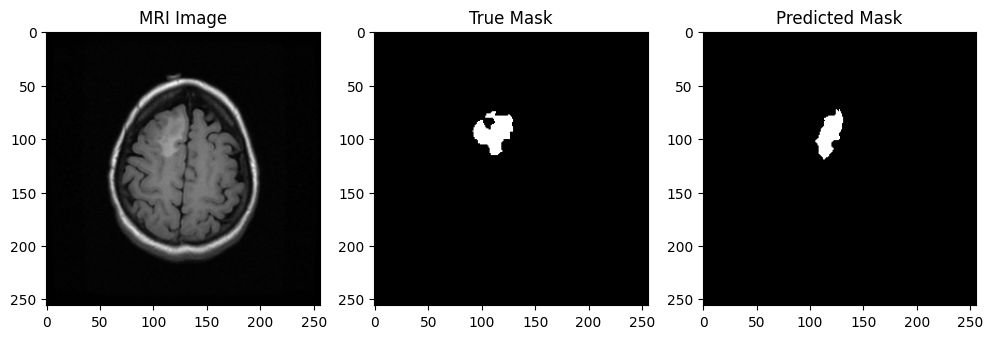

In [53]:

def plot_sample(index):
    img = X_val[index]
    true_mask = y_val[index]
    pred_mask = model.predict(img[np.newaxis, ...])[0]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("MRI Image")
    plt.imshow(img.squeeze(), cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(true_mask.squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow((pred_mask.squeeze() > 0.5), cmap='gray')

    plt.show()

# Display a random prediction
plot_sample(random.randint(0, len(X_val)-1))


In [34]:

unique_vals = np.unique(y_train[300])
print("Unique values in mask:", unique_vals)


Unique values in mask: [0 1]


Unique values in mask: [0 1]


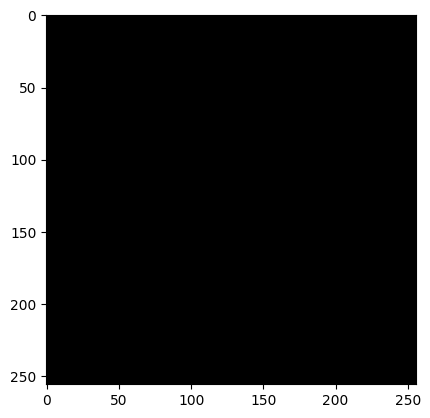

In [32]:
print("Unique values in mask:", np.unique(y[3000]))
plt.imshow(y[0].squeeze(), cmap='gray')


In [35]:
# خليك بس في الصور المصابة
positive_df = brain_df[brain_df['mask'] == 1]
print(f"Number of positive samples: {len(positive_df)}")


Number of positive samples: 1373


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


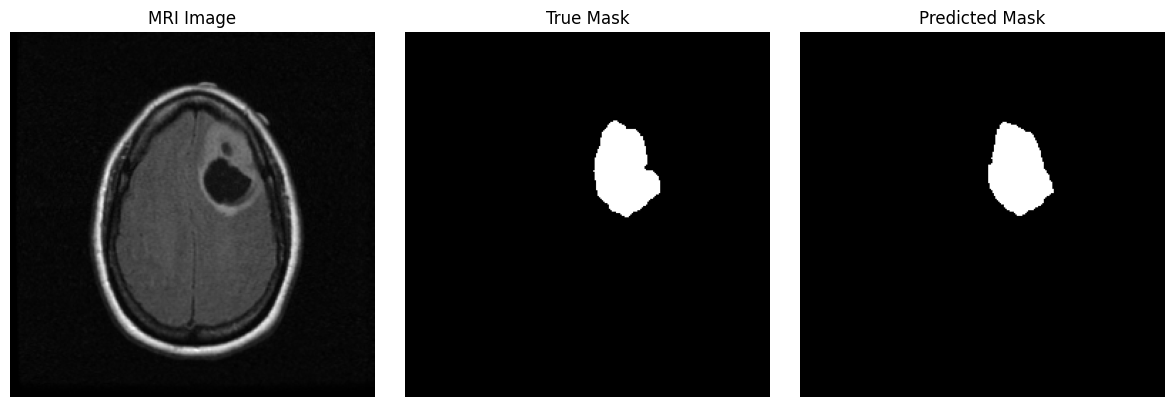

In [41]:
sample = positive_df.sample(1).iloc[0]
image_path = sample['image_path']
mask_path = sample['mask_path']

image = preprocess_image(image_path, is_mask=False)
true_mask = preprocess_image(mask_path, is_mask=True)

pred_mask = model.predict(image[np.newaxis, ...])[0]

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("MRI Image")
plt.imshow(image.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow((pred_mask.squeeze() > 0.5), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


In [42]:
negative_df = brain_df[brain_df['mask'] == 0]
print(f"Number of negative samples: {len(negative_df)}")


Number of negative samples: 2556


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


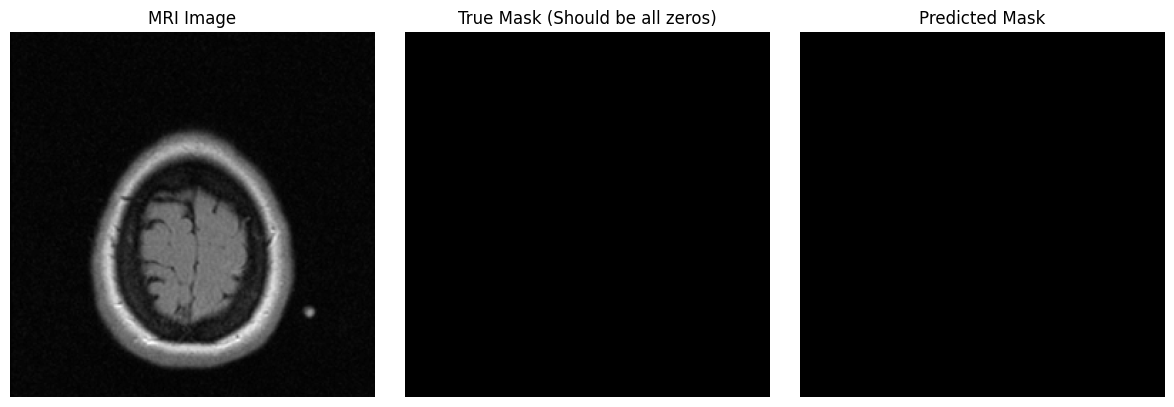

In [46]:
sample = negative_df.sample(1).iloc[0]
image_path = sample['image_path']
mask_path = sample['mask_path']

image = preprocess_image(image_path, is_mask=False)
true_mask = preprocess_image(mask_path, is_mask=True)

pred_mask = model.predict(image[np.newaxis, ...])[0]

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("MRI Image")
plt.imshow(image.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("True Mask (Should be all zeros)")
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow((pred_mask.squeeze() > 0.5), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


In [54]:
model.save("brain_mri_unet_model.h5")


In [57]:
from tensorflow.keras.models import load_model

model_loaded = load_model("brain_mri_unet_model.h5")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


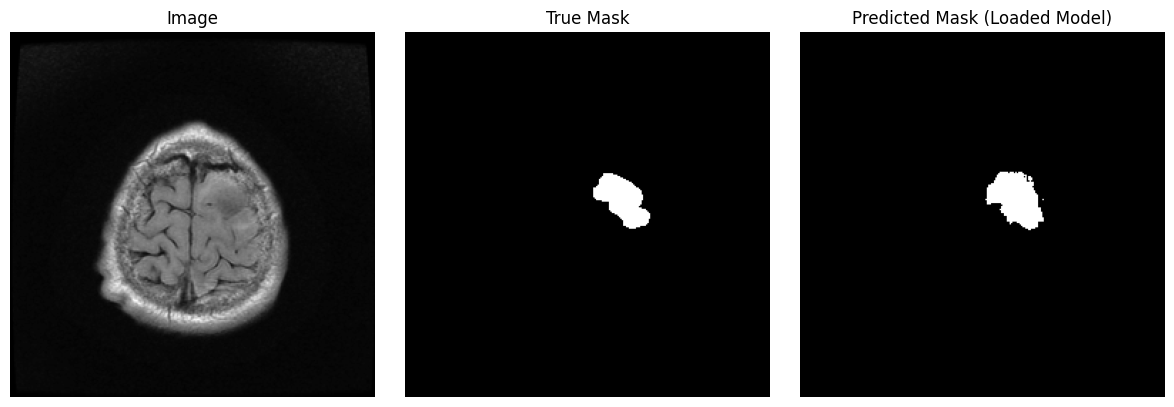

In [58]:
sample = brain_df[brain_df['mask'] == 1].sample(1).iloc[0]

image_path = sample['image_path']
mask_path = sample['mask_path']

image = preprocess_image(image_path, is_mask=False)
true_mask = preprocess_image(mask_path, is_mask=True)

pred_mask = model_loaded.predict(image[np.newaxis, ...])[0]

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(image.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask (Loaded Model)")
plt.imshow((pred_mask.squeeze() > 0.5), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()
